# Analyse de sensibilité globale par regression - application au cas de la déviation verticale de la poutre


## Déviation  verticale d'une poutre encastrée

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\} $
* $E$ : Young modulus (Pa)
* $F$ : Loading (N),
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4).

|Variable|  Distribution|
| ------------- |-------------|
|E|  Beta(r = 0.9, t = 3.5, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L|Uniform(min=250.0, max= 260.0)|
|I| Beta(r = 2.5, t = 4.0, a = 310, b = 450)|

In the previous table $\mu_F=E(F)$ and $\sigma_F=\sqrt{V(F)}$ are the mean and the standard deviation of $F$.

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

# Model definition

In [1]:
import openturns as ot
import numpy as np

In [2]:
ot.ResourceMap.SetAsString('R-executable-command','C:\\Users\\c61372\\AppData\\Local\\Continuum\\anaconda3-5-3\\Lib\\R\\bin\\R.exe')

In [3]:
dist_E = ot.Beta(0.9, 3.1, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250., 260.) # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 4, 310., 450.) # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [4]:
g = ot.SymbolicFunction( ["E","F","L","I"],["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un méchanisme d'historique.

In [5]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [6]:
XRV = ot.RandomVector(X)
Y = ot.RandomVector(g, XRV)
Y.setDescription(['Y (cm)'])

## Régression linéaire avec LinearLeastSquares

In [7]:
n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

In [8]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)

In [9]:
myLeastSquares.run()
responseSurface = myLeastSquares.getResponseSurface()
responseSurface

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=4 values=[0,0,0,0] constant=class=Point name=Unnamed dimension=1 values=[0.000371894] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.53343e-07,0.000422248,0.0985606,-0.0331838] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.53343e-07,0.000422248,0.0985606,-0.0331838] hessianImplementation=class=ConstantHessian name=Unnamed constant=class=SymmetricTensor implementation=class=TensorImplementation name=Unnamed rows=4 columns=4 sheets=1 values=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [10]:
val = ot.MetaModelValidation(sampleX, sampleY, responseSurface)

In [11]:
q2 = val.computePredictivityFactor()
q2

0.9761937158394096

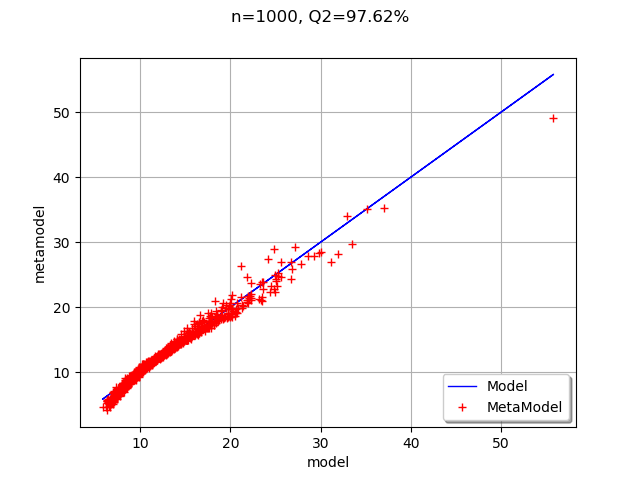

In [12]:
graph = val.drawValidation()
graph.setTitle("n=%d, Q2=%.2f%%" % (n,q2*100))
graph

In [13]:
indices = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
indices

class=Point name=Unnamed dimension=4 values=[0.130762,0.811694,0.0105332,0.0470115]

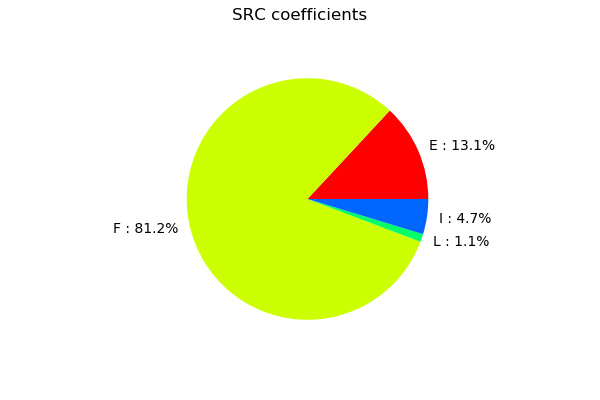

In [14]:
input_names = g.getInputDescription()
ot.SaltelliSensitivityAlgorithm.DrawImportanceFactors(indices, input_names, 'SRC coefficients')

Nous pouvons comparer les résultats que nous avions obtenu par la méthode du développement de Taylor. 

| Méthode | E | F | L | I |
|---|---|---|---|---|
| Taylor | 0.1535 | 0.7856 | 0.0101 | 0.0508 |
| Regression | 0.1307 | 0.8117 | 0.0105 | 0.0470 |

On peut remarquer que, dans ce cas particulier, les deux méthodes donnent des résultats très similaires. En effet, 
- la méthode fondée sur le développement de Taylor fait l'hypothèse locale d'un comportement linéaire au voisinage du point moyen $E(X)$,
- la méthode fondée sur la regression linéaire fait l'hypothèse globale d'un comportement linéaire sur le domaine du vecteur aléatoire $X$.

Puisque, dans notre application, la combinaison particulière des lois marginales et de la fonction $g$ mènent à un comportement approximativement linéaire, les deux méthodes produisent des résultats similaires.

## Exercice 1 : TODO

## Exercice 2 : TODO

## Exercice 3 : TODO

## Annexe : régression linéaire avec LinearModelFactory

In [15]:
LMF = ot.LinearModelFactory()
linearModel = LMF.build(sampleX, sampleY)
linearModel

class=LinearModel name=Unnamed regression=class=Point name=Unnamed dimension=5 values=[-16.7859,-3.49017e-07,0.000422397,0.162234,-0.0321896] confidence intervals=class=Interval name=Unnamed dimension=5 lower bound=class=Point name=Unnamed dimension=5 values=[-20.0869,-3.5677e-07,0.000418631,0.149534,-0.0333825] upper bound=class=Point name=Unnamed dimension=5 values=[-13.4849,-3.41264e-07,0.000426164,0.174935,-0.0309967] finite lower bound=[1,1,1,1,1] finite upper bound=[1,1,1,1,1] p-Values=[1.99663e-16,0,0,1.9471e-81,3.15934e-238]

In [16]:
linearModel.getRegression()

class=Point name=Unnamed dimension=5 values=[-16.7859,-3.49017e-07,0.000422397,0.162234,-0.0321896]

Calcule le R2.

In [17]:
predictions = linearModel.getPredicted(sampleX)
residuals = sampleY-predictions
SSRes = residuals.computeRawMoment(2)[0]
SSTot = sampleY.computeCenteredMoment(2)[0]
R2 = 1.0 - SSRes / SSTot
R2

0.9777583418308503

In [18]:
linearModel.getConfidenceIntervals()

class=Interval name=Unnamed dimension=5 lower bound=class=Point name=Unnamed dimension=5 values=[-20.0869,-3.5677e-07,0.000418631,0.149534,-0.0333825] upper bound=class=Point name=Unnamed dimension=5 values=[-13.4849,-3.41264e-07,0.000426164,0.174935,-0.0309967] finite lower bound=[1,1,1,1,1] finite upper bound=[1,1,1,1,1]

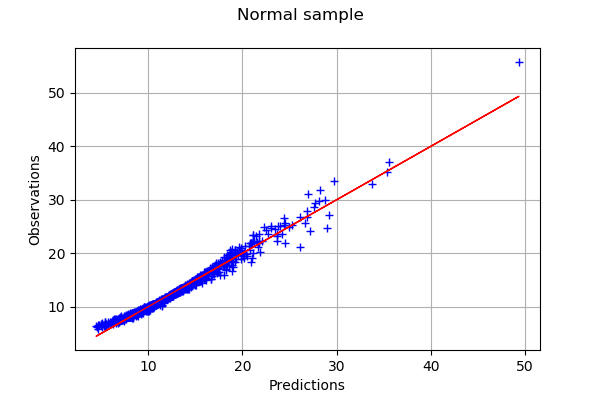

In [22]:
graph = ot.Graph('Normal sample', 'x1', 'x2', True, '')
graph.setXTitle("Predictions")
graph.setYTitle("Observations")
cloud = ot.Cloud(predictions,sampleY)
curve = ot.Curve(predictions,predictions)
curve.setColor("red")
graph.add(cloud)
graph.add(curve)
graph